We'd like to study how out model performs when applying various analyses to datasets not seen during its training. Here, we examine this problem using the set of human CDR3 TRB sequences.

In [1]:
# clear memory
%reset -f

In [2]:
cd ..

/home/romi/projects/preTCR


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os, sys
import logging
import json
import tempfile
import itertools
import collections
import importlib
import matplotlib
import tqdm
import numpy as np
import pandas as pd
from sklearn import metrics
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc

import torch
import torch.nn as nn
import skorch
import skorch.helper

import ipywidgets
import jupyter
from ipywidgets import FloatProgress

from transformers import BertModel, BertForMaskedLM, BertTokenizer, FeatureExtractionPipeline

SRC_DIR = "tcr"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
from tcr import custom_metrics
#import data_loader as dl
from tcr import featurization as ft
from tcr import canonical_models as models
from tcr import model_utils
from tcr import muscle
from tcr import plot_utils
from tcr import utils
from lab_notebooks.utils import TRANSFORMER, DEVICE, DATA_DIR
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)
import transformer_custom as trans
import conv

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

'plots/CDR3_data_plots'

In [5]:
# generate matplotlib colors with names (for UMAP)
import matplotlib.colors as mcolors
def format_color_groups(df, color):
    x = df.copy()
    i = 0

    for factor in color:
        x.iloc[i, :-1] = ''
        style = f'background-color: {color[i]}'
        x.loc[i, 'display color as background'] = style
        i = i + 1

    return x

colors = {
    'name': mcolors.CSS4_COLORS.keys(),
    'hex': mcolors.CSS4_COLORS.values()
}
df_colors = pd.DataFrame(colors)
df_colors['rgb'] = df_colors['hex'].apply(mcolors.hex2color)
df_colors['rgb'] = df_colors['rgb'].apply(lambda x:[round(c, 5) for c in x])
df_colors['display color as background'] = ''
df_colors.style.apply(format_color_groups, color=df_colors.hex,  axis=None)



In [6]:
# list of color names
list(df_colors['name'][5:20])
df_colors[5:20]

name      hex                          rgb  \
5            beige  #F5F5DC  [0.96078, 0.96078, 0.86275]   
6           bisque  #FFE4C4      [1.0, 0.89412, 0.76863]   
7            black  #000000              [0.0, 0.0, 0.0]   
8   blanchedalmond  #FFEBCD      [1.0, 0.92157, 0.80392]   
9             blue  #0000FF              [0.0, 0.0, 1.0]   
10      blueviolet  #8A2BE2  [0.54118, 0.16863, 0.88627]   
11           brown  #A52A2A  [0.64706, 0.16471, 0.16471]   
12       burlywood  #DEB887  [0.87059, 0.72157, 0.52941]   
13       cadetblue  #5F9EA0  [0.37255, 0.61961, 0.62745]   
14      chartreuse  #7FFF00          [0.49804, 1.0, 0.0]   
15       chocolate  #D2691E  [0.82353, 0.41176, 0.11765]   
16           coral  #FF7F50      [1.0, 0.49804, 0.31373]   
17  cornflowerblue  #6495ED  [0.39216, 0.58431, 0.92941]   
18        cornsilk  #FFF8DC      [1.0, 0.97255, 0.86275]   
19         crimson  #DC143C  [0.86275, 0.07843, 0.23529]   

   display color as background  
5                               
6                               
7                               
8                               
9                               
10                              
11                              
12                              
13                              
14                              
15                              
16                              
17                              
18                              
19

#### Prepare Data

In [7]:
gene_type = 'V' #'J'

In [8]:
# data with j gene
if gene_type == 'J':
    data_dir = DATA_DIR + "sequences_j_gene_csv_17M.csv"
else:
    data_dir = DATA_DIR + "sequences_v_gene_csv_17M_pub_priv.csv"

In [9]:
# load data
# read db data for db data : gene_type gene analysis
tcr_data_gene = pd.read_csv(data_dir,engine="pyarrow")
data_to_use = tcr_data_gene
data_to_use.head()

Sequences  Appearances  Private_Public_label            v_gene
0  0  CASSLGETQYF          788                     1  TCRBV12-03/12-04
1  1  CASSLGETQYF          788                     1        TCRBV27-01
2  2  CASSLGETQYF          788                     1        TCRBV07-09
3  3  CASSLGETQYF          788                     1        TCRBV05-06
4  4  CASSLGETQYF          788                     1        TCRBV11-02

In [10]:
len(data_to_use)

14938529

In [11]:
# edit column names
if gene_type=='J':
    data_to_use.rename(columns={'j_gene': 'jGeneName'}, inplace=True)
else:
    data_to_use.rename(columns={'v_gene': 'vGeneName'}, inplace=True)

#### Display Genes

In [12]:
if gene_type=='J':
    gene_name = 'jGeneName'
else:
    gene_name = 'vGeneName'

In [13]:
len(collections.Counter(data_to_use[gene_name]))

72

In [14]:
collections.Counter(data_to_use[gene_name])

Counter({'TCRBV12-03/12-04': 175823,
         'TCRBV27-01': 550034,
         'TCRBV07-09': 537203,
         'TCRBV05-06': 252471,
         'TCRBV11-02': 342192,
         'TCRBV07-08': 223154,
         'TCRBV11-03': 153311,
         'TCRBV05-01': 830243,
         'TCRBV06-05': 630411,
         'TCRBV07-02': 516068,
         'TCRBV05-08': 98023,
         'TCRBV03-01/03-02': 510656,
         'unresolved': 2081879,
         'TCRBV28-01': 738761,
         'TCRBV11-01': 56861,
         'TCRBV14-01': 159945,
         'TCRBV04-01': 317133,
         'TCRBV05-04': 320133,
         'TCRBV06-02': 49141,
         'TCRBV05-05': 153562,
         'TCRBV19-01': 854789,
         'TCRBV07-03': 229302,
         'TCRBV09-01': 511008,
         'TCRBV07-06': 140063,
         'TCRBV07-07': 40832,
         'TCRBV13-01': 101639,
         'TCRBV18-01': 418196,
         'TCRBV02-01': 597700,
         'TCRBV04-02': 191069,
         'TCRBV25-01': 134877,
         'TCRBV06-02/06-03': 204526,
         'TCRBV06-06': 1

In [15]:
# remove irrelevant row
if gene_type=='J':
    data_to_use_filtered = data_to_use[data_to_use[gene_name] != 'unresolved']
    data_to_use_filtered = data_to_use_filtered[data_to_use_filtered[gene_name] != 'TCRBJ02-02P']
else:
    data_to_use_filtered = data_to_use[data_to_use[gene_name] != 'unresolved']
    data_to_use_filtered = data_to_use_filtered[~data_to_use_filtered[gene_name].str.contains('-or', regex=False)]
    # remove genes that their count is less than 200
    data_to_use_filtered = data_to_use_filtered[data_to_use_filtered.groupby(gene_name)[gene_name].transform('count') > 40000]
collections.Counter(data_to_use_filtered[gene_name])

Counter({'TCRBV12-03/12-04': 175823,
         'TCRBV27-01': 550034,
         'TCRBV07-09': 537203,
         'TCRBV05-06': 252471,
         'TCRBV11-02': 342192,
         'TCRBV07-08': 223154,
         'TCRBV11-03': 153311,
         'TCRBV05-01': 830243,
         'TCRBV06-05': 630411,
         'TCRBV07-02': 516068,
         'TCRBV05-08': 98023,
         'TCRBV03-01/03-02': 510656,
         'TCRBV28-01': 738761,
         'TCRBV11-01': 56861,
         'TCRBV14-01': 159945,
         'TCRBV04-01': 317133,
         'TCRBV05-04': 320133,
         'TCRBV06-02': 49141,
         'TCRBV05-05': 153562,
         'TCRBV19-01': 854789,
         'TCRBV07-03': 229302,
         'TCRBV09-01': 511008,
         'TCRBV07-06': 140063,
         'TCRBV07-07': 40832,
         'TCRBV13-01': 101639,
         'TCRBV18-01': 418196,
         'TCRBV02-01': 597700,
         'TCRBV04-02': 191069,
         'TCRBV25-01': 134877,
         'TCRBV06-02/06-03': 204526,
         'TCRBV06-06': 183976,
         'TCRBV10-02': 86

In [16]:
list(collections.Counter(data_to_use_filtered[gene_name]).keys())

['TCRBV12-03/12-04',
 'TCRBV27-01',
 'TCRBV07-09',
 'TCRBV05-06',
 'TCRBV11-02',
 'TCRBV07-08',
 'TCRBV11-03',
 'TCRBV05-01',
 'TCRBV06-05',
 'TCRBV07-02',
 'TCRBV05-08',
 'TCRBV03-01/03-02',
 'TCRBV28-01',
 'TCRBV11-01',
 'TCRBV14-01',
 'TCRBV04-01',
 'TCRBV05-04',
 'TCRBV06-02',
 'TCRBV05-05',
 'TCRBV19-01',
 'TCRBV07-03',
 'TCRBV09-01',
 'TCRBV07-06',
 'TCRBV07-07',
 'TCRBV13-01',
 'TCRBV18-01',
 'TCRBV02-01',
 'TCRBV04-02',
 'TCRBV25-01',
 'TCRBV06-02/06-03',
 'TCRBV06-06',
 'TCRBV10-02',
 'TCRBV30-01',
 'TCRBV10-01',
 'TCRBV04-03',
 'TCRBV06-01',
 'TCRBV12-05',
 'TCRBV21-01',
 'TCRBV10-03',
 'TCRBV06-04',
 'TCRBV23-01',
 'TCRBV24-01',
 'TCRBV15-01',
 'TCRBV29-01',
 'TCRBV20-01']

In [17]:
# search specific v genes
data_to_use_filtered = data_to_use[data_to_use[gene_name] != 'unresolved']
v_genes_to_use = ['TCRBV9-01','TCRBV6-05','TCRBV10-03','TCRBV15-01','TCRBV18-01' ,'TCRBV19-01','TCRBV20-01','TCRBV24-01','TCRBV29-01','TCRBV30-01']
data_to_use_filtered = data_to_use_filtered[data_to_use_filtered[gene_name].str.contains('|'.join(v_genes_to_use))]
collections.Counter(data_to_use_filtered[gene_name])

Counter({'TCRBV19-01': 854789,
         'TCRBV18-01': 418196,
         'TCRBV30-01': 387717,
         'TCRBV10-03': 288601,
         'TCRBV24-01': 242407,
         'TCRBV15-01': 204179,
         'TCRBV29-01': 341504,
         'TCRBV20-01': 140195})

In [18]:
genes = collections.Counter(data_to_use_filtered[gene_name])

In [19]:
# create list of genes that are string
genes_keys = list(genes.keys())
genes_keys_str = []
for key in genes_keys:
    if isinstance(key, str):
        genes_keys_str.append(key)

# create dictionary with genes_keys_str as keys and genes as values
genes_dict = dict(zip(genes_keys_str, genes.values()))

for key in genes_dict.keys():
    if not isinstance(key, str):
        print(type(key))
len(genes_dict.keys())

8

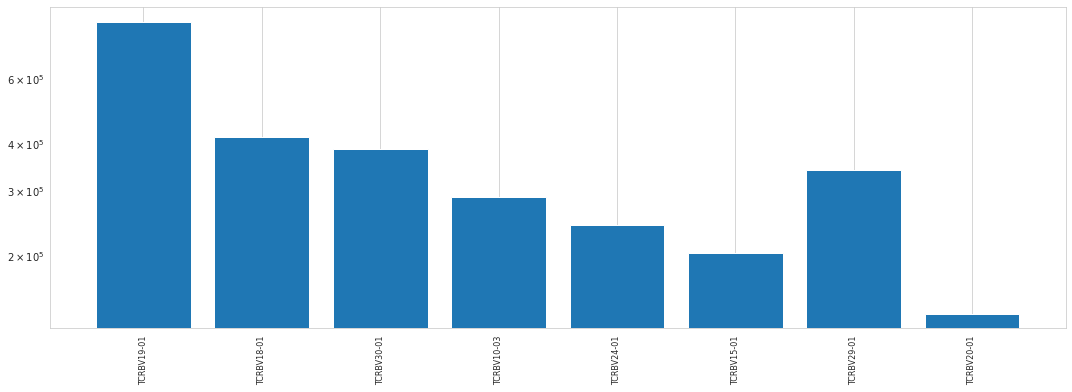

In [20]:
# bar plot
plt.bar(genes_dict.keys(), genes_dict.values())
# change y axis to log scale
plt.yscale('log')
# make the plot larger
plt.gcf().set_size_inches(15, 5)
# wider bars for better visualization
plt.tight_layout()
# make x axis labels horizontal and smaller
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
# show plot
plt.show()

In [21]:
# extract duplicate sequences
duplicate_seq = data_to_use_filtered[data_to_use_filtered['Sequences'].duplicated(keep=False)]
duplicate_seq = duplicate_seq[['Sequences', 'Appearances', 'Private_Public_label', gene_name]]
duplicate_seq

Sequences  Appearances  Private_Public_label   vGeneName
20          CASSLGETQYF          788                     1  TCRBV19-01
26          CASSLGETQYF          788                     1  TCRBV18-01
54        CASSLGGNTEAFF          636                     1  TCRBV30-01
55        CASSLGGNTEAFF          636                     1  TCRBV19-01
63        CASSLGGNTEAFF          636                     1  TCRBV18-01
...                 ...          ...                   ...         ...
4463872  CATRRGTSGNTIYF            2                     1  TCRBV15-01
4464012     CSVGYQETQYF            2                     1  TCRBV29-01
4464013     CSVGYQETQYF            2                     1  TCRBV20-01
4464092     CSPFKGETQYF            2                     1  TCRBV20-01
4464093     CSPFKGETQYF            2                     1  TCRBV29-01

[107583 rows x 4 columns]

In [22]:
# keep the first instance of each sequence
duplicate_seq_to_remove = duplicate_seq['Sequences'].tolist()
df = pd.DataFrame(duplicate_seq_to_remove, columns=['Sequences'])
seq_to_remove_no_dup = list(df.drop_duplicates(keep="first")['Sequences'])
len(seq_to_remove_no_dup)

52740

In [23]:
# remove duplicate sequences from data (that are in seq_to_remove_no_dup)
data_to_use_filtered_no_dup = data_to_use_filtered[~data_to_use_filtered['Sequences'].isin(seq_to_remove_no_dup)]

In [24]:
data_to_use_filtered_no_dup = data_to_use_filtered_no_dup[['Sequences', 'Appearances', 'Private_Public_label', gene_name]]
data_to_use_filtered_no_dup

Sequences  Appearances  Private_Public_label   vGeneName
3929            CASSLVGNTEAFF          287                     1  TCRBV19-01
4532              CASSLDYEQYF          275                     1  TCRBV18-01
4564              CASSYSYEQYF          275                     1  TCRBV18-01
5604            CASSLAGNYGYTF          253                     1  TCRBV18-01
6095             CASSLVGETQYF          248                     1  TCRBV19-01
...                       ...          ...                   ...         ...
14938520      CSAAPGPKPQNIQYF            1                     0  TCRBV29-01
14938521     CSVEQAAGGIGNTIYF            1                     0  TCRBV29-01
14938523    CAISESNGGASGNTIYF            1                     0  TCRBV10-03
14938524  CASLTRDSTTIPSGNTIYF            1                     0  TCRBV19-01
14938528        CAWTMGGNHEAFF            1                     0  TCRBV30-01

[2770005 rows x 4 columns]

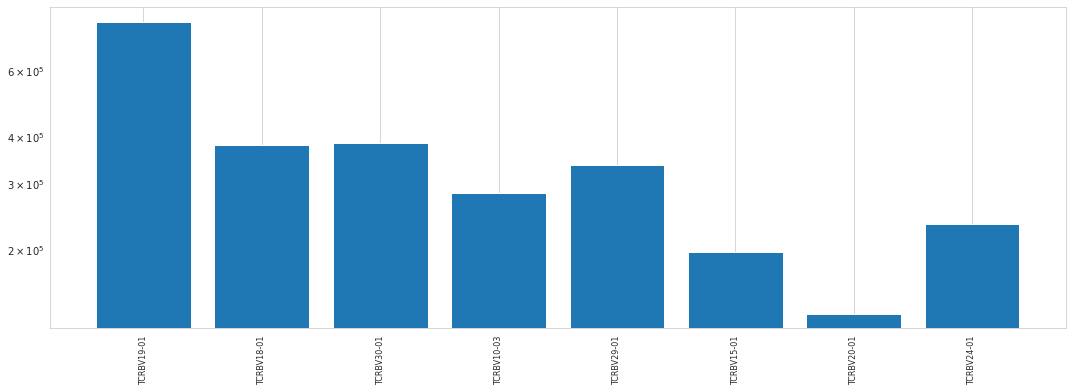

In [25]:
genes_no_dup = collections.Counter(data_to_use_filtered_no_dup[gene_name])
# bar plot
plt.bar(genes_no_dup.keys(), genes_no_dup.values())
# change y axis to log scale
plt.yscale('log')
# make the plot larger
plt.gcf().set_size_inches(15, 5)
# wider bars for better visualization
plt.tight_layout()
# make x axis labels horizontal and smaller
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
# show plot
plt.show()

In [26]:
genes_no_dup

Counter({'TCRBV19-01': 813614,
         'TCRBV18-01': 381766,
         'TCRBV30-01': 385557,
         'TCRBV10-03': 284286,
         'TCRBV29-01': 336560,
         'TCRBV15-01': 198028,
         'TCRBV20-01': 135252,
         'TCRBV24-01': 234942})

In [27]:
# Resamples df_counts into df_counts_small
# in data_to_use_filtered_nona_TCRBV_no_dup group by vGeneName and keep 3% of each group
def filter_data(df):
    if len(df) < 10000:
        return df
    else:
        return df.sample(frac=0.5, random_state=3)

In [28]:
gene_small_set = data_to_use_filtered_no_dup.groupby(gene_name, sort=False).apply(filter_data).reset_index(drop=True)
gene_small_set

Sequences  Appearances  Private_Public_label   vGeneName
0             CASSSDRRFYEQYF            1                     0  TCRBV19-01
1           CASSIATASGRDTQYF            1                     0  TCRBV19-01
2              CASSPLGGLGQYF            2                     1  TCRBV19-01
3        CASSIVWGSIGRGGNIQYF            1                     0  TCRBV19-01
4            CASSDGGTGSNEQFF            1                     0  TCRBV19-01
...                      ...          ...                   ...         ...
1384997      CATSDSDRGSYGYTF            1                     0  TCRBV24-01
1384998    CATSDVVPGPTYNEQFF            1                     0  TCRBV24-01
1384999     CATSGSLAGVLHEQFF            1                     0  TCRBV24-01
1385000   CATSDYGSGPSSYNEQFF            1                     0  TCRBV24-01
1385001     CATSDLRGASYNEQFF            3                     1  TCRBV24-01

[1385002 rows x 4 columns]

In [29]:
if gene_type=='J':
    gene_small_set.jGeneName.value_counts()
else:
    gene_small_set.vGeneName.value_counts()

In [30]:
tcrb_data_sample = gene_small_set

In [31]:
tcrb_data_sample

Sequences  Appearances  Private_Public_label   vGeneName
0             CASSSDRRFYEQYF            1                     0  TCRBV19-01
1           CASSIATASGRDTQYF            1                     0  TCRBV19-01
2              CASSPLGGLGQYF            2                     1  TCRBV19-01
3        CASSIVWGSIGRGGNIQYF            1                     0  TCRBV19-01
4            CASSDGGTGSNEQFF            1                     0  TCRBV19-01
...                      ...          ...                   ...         ...
1384997      CATSDSDRGSYGYTF            1                     0  TCRBV24-01
1384998    CATSDVVPGPTYNEQFF            1                     0  TCRBV24-01
1384999     CATSGSLAGVLHEQFF            1                     0  TCRBV24-01
1385000   CATSDYGSGPSSYNEQFF            1                     0  TCRBV24-01
1385001     CATSDLRGASYNEQFF            3                     1  TCRBV24-01

[1385002 rows x 4 columns]

In [49]:
# take 10 random sequences from each j Gene
# if gene_type=='J':
#     j_gene_sequences = data_to_use_filtered.groupby(gene_type, sort=False).apply(lambda x: x.sample(10)).reset_index(drop=True)
#     j_gene_sequences.to_csv('/home/romi/projects/preTCR/CDR3_data/cdr3_by_jgene_groups.csv')

#### Create and Display embeddings

In [32]:
if gene_type == 'J':
    tcrb_data_sample.to_csv('/home/romi/projects/preTCR/CDR3_data/jgene_embed_full_data.csv')
else:
    # tcrb_data_sample.to_csv('/home/romi/projects/preTCR/CDR3_data/vgene_data_classfy1.csv')
    # The 8 specific v genes prone to be more public
    tcrb_data_sample.to_csv('/home/romi/projects/preTCR/CDR3_data/vgene_public_specific_data.csv')

In [33]:
tcrb_data_sample

Sequences  Appearances  Private_Public_label   vGeneName
0             CASSSDRRFYEQYF            1                     0  TCRBV19-01
1           CASSIATASGRDTQYF            1                     0  TCRBV19-01
2              CASSPLGGLGQYF            2                     1  TCRBV19-01
3        CASSIVWGSIGRGGNIQYF            1                     0  TCRBV19-01
4            CASSDGGTGSNEQFF            1                     0  TCRBV19-01
...                      ...          ...                   ...         ...
1384997      CATSDSDRGSYGYTF            1                     0  TCRBV24-01
1384998    CATSDVVPGPTYNEQFF            1                     0  TCRBV24-01
1384999     CATSGSLAGVLHEQFF            1                     0  TCRBV24-01
1385000   CATSDYGSGPSSYNEQFF            1                     0  TCRBV24-01
1385001     CATSDLRGASYNEQFF            3                     1  TCRBV24-01

[1385002 rows x 4 columns]

In [52]:
# create embeddings
embedding_kwargs = {"method": "mean", "layers": [-1]}
tcrb_embeddings = model_utils.get_transformer_embeddings(
    TRANSFORMER, list(tcrb_data_sample['Sequences']), **embedding_kwargs,
    device=DEVICE, batch_size=1024)
tcrb_embeddings.shape

KeyboardInterrupt: 

In [ ]:
# output embeddings to csv
if gene_type == 'J':
    output_path = "/home/romi/projects/preTCR/CDR3_data/j_gene_embeddings.csv"
else:
    output_path = "/home/romi/projects/preTCR/CDR3_data/v_gene_embeddings.csv"
tcrb_embeddings_df = pd.DataFrame(tcrb_embeddings)
tcrb_embeddings_df.to_csv(output_path)

In [34]:
# calculate pca, umap of embeddings
tcrb_embeddings_adata = ad.AnnData(
    tcrb_embeddings,
    obs=tcrb_data_sample,
)
sc.pp.pca(tcrb_embeddings_adata, n_comps=50)
sc.pp.neighbors(tcrb_embeddings_adata)
sc.tl.umap(tcrb_embeddings_adata)
tcrb_embeddings_adata

/opt/conda/envs/tcrbert/lib/python3.9/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1385002 × 768
    obs: 'Sequences', 'Appearances', 'Private_Public_label', 'vGeneName'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

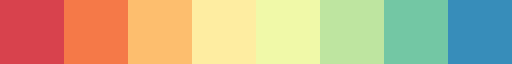

In [35]:
from matplotlib.colors import ListedColormap
# Create colormap of 16 shades of blues
color_map = ListedColormap(sns.color_palette("Spectral", len(genes_dict.keys())))

# Reverse the cmap colors
#cmap = cmap.reversed()
color_map

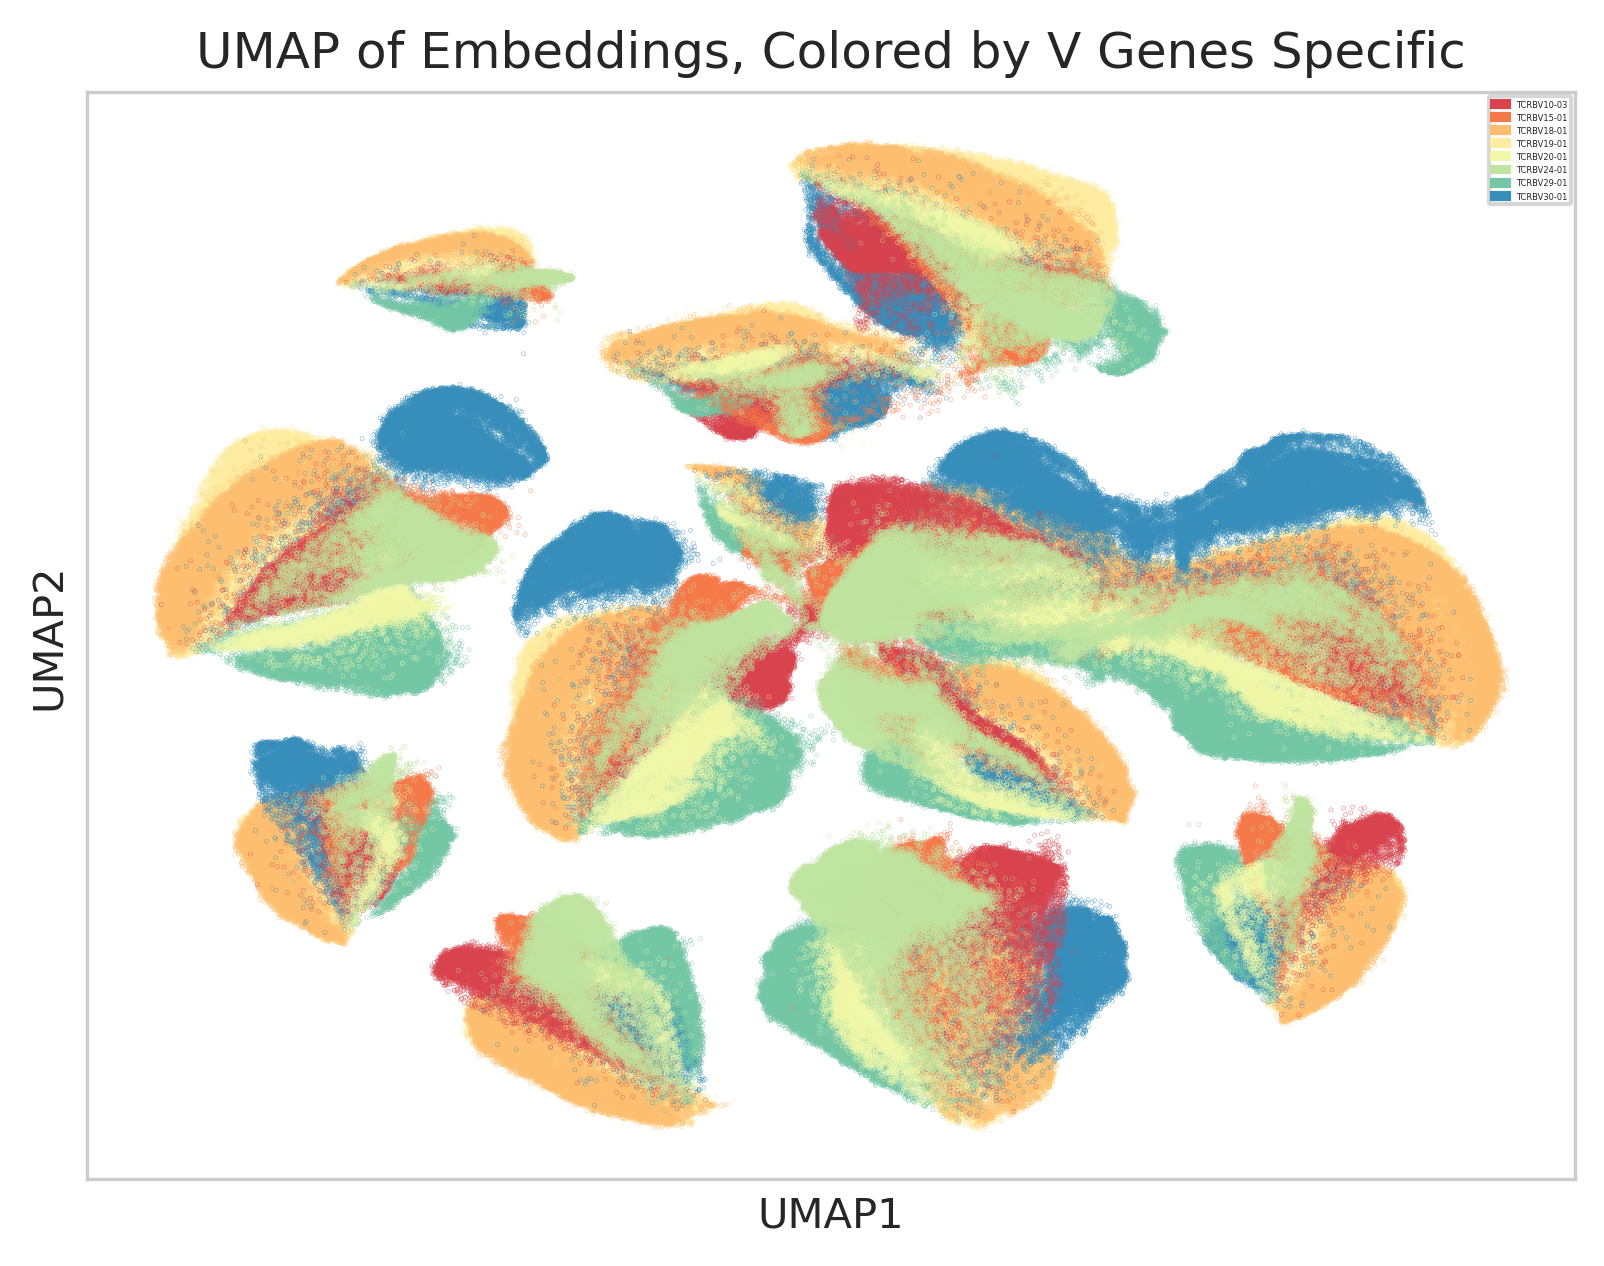

In [36]:
colors = ['gold', 'darkblue']#, 'maroon'] #cmap=plt.get_cmap('Set1)'
importlib.reload(plot_utils)
plot_utils.plot_anndata_rep(
    tcrb_embeddings_adata,
    # color='jGeneName',
    color='vGeneName',
    # color='Private_Public_label',
    direct_label=False,
    cmap= color_map,
    # cmap=matplotlib.colors.ListedColormap(colors),
    #title="UMAP of Embeddings, Colored by J Genes",
    title="UMAP of Embeddings, Colored by V Genes Specific",
    # title="UMAP of Embeddings, Colored by Public/Private Label",
    legend_size=2,
    # fname=os.path.join(PLOT_DIR, "tcr_model_db_data_umap_j_genes.pdf"),
    fname=os.path.join(PLOT_DIR, "tcr_model_db_data_umap_v_genes_specific.pdf"),
    # fname=os.path.join(PLOT_DIR, "tcr_model_db_data_umap_j_genes_pub_priv.pdf"),
).show()

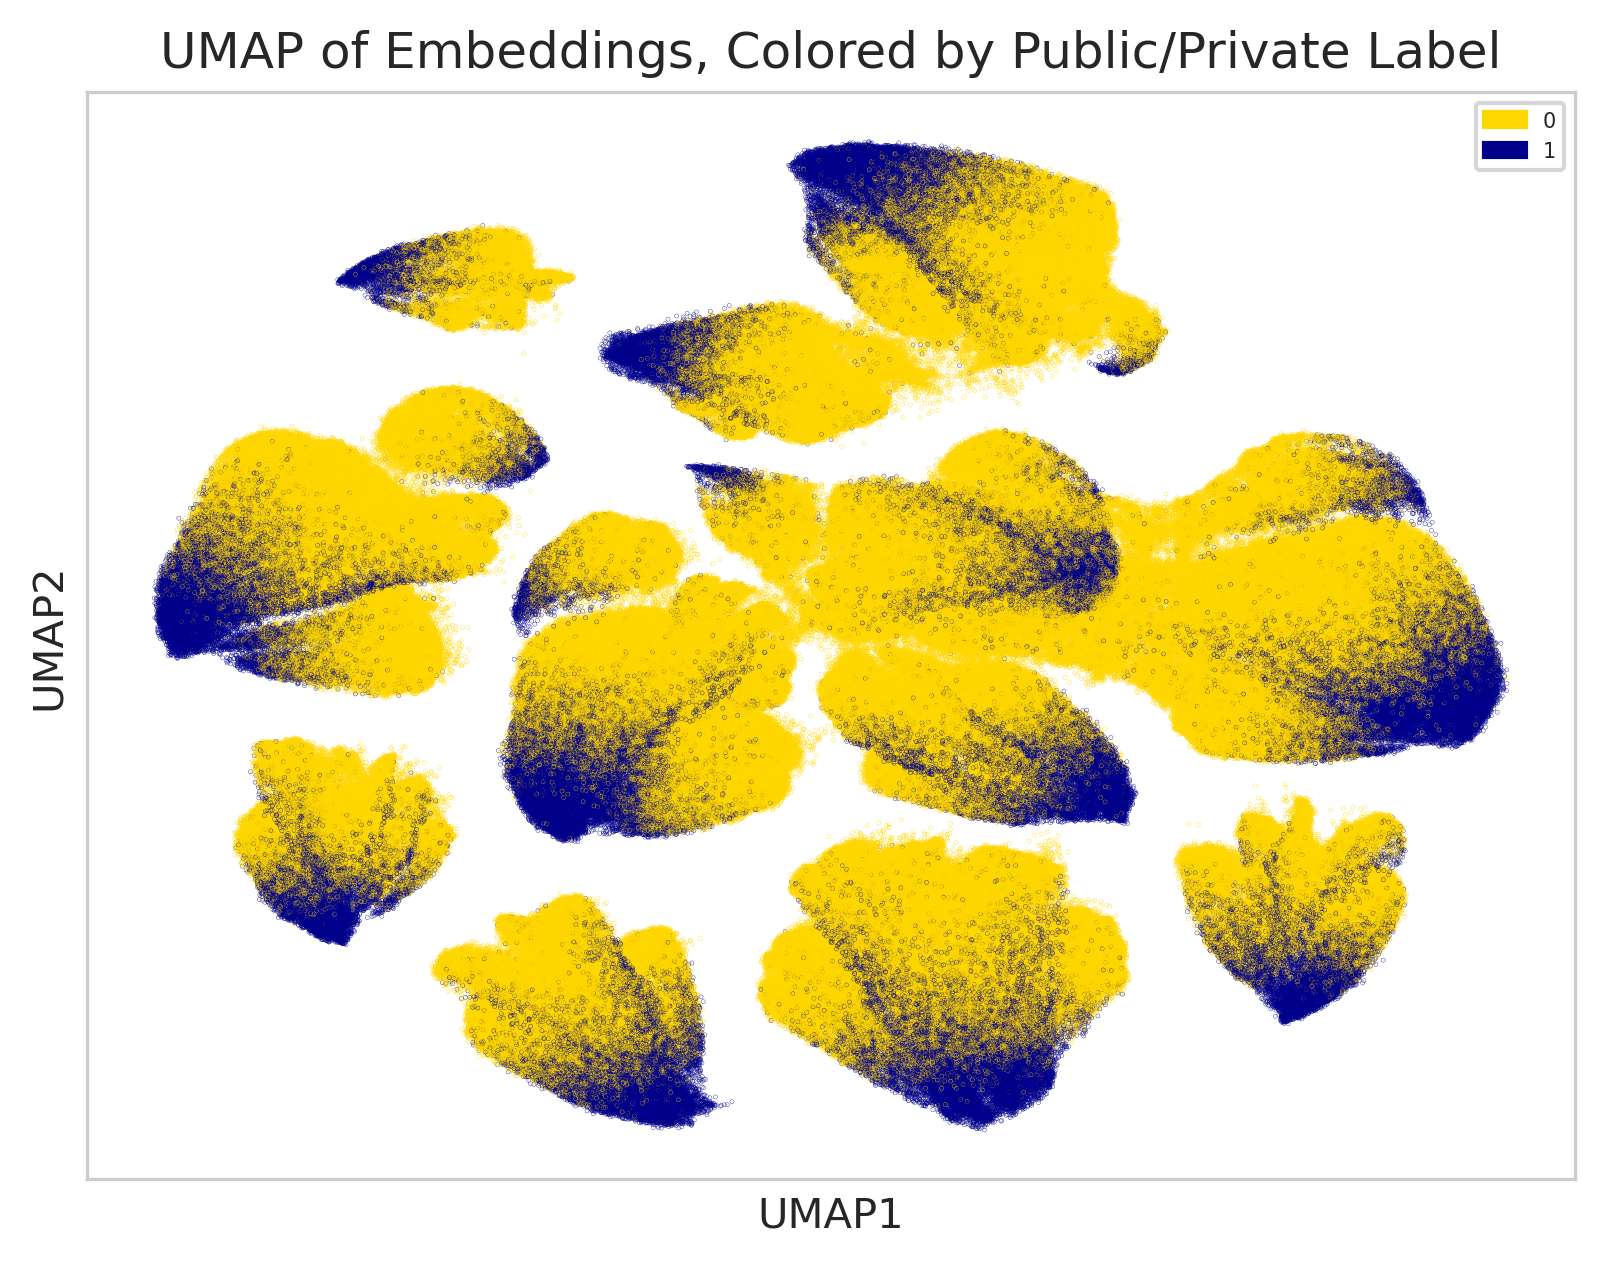

In [37]:
colors = ['gold', 'darkblue']#, 'maroon'] #cmap=plt.get_cmap('Set1)'
importlib.reload(plot_utils)
plot_utils.plot_anndata_rep(
    tcrb_embeddings_adata,
    # color='jGeneName',
    color='Private_Public_label',
    direct_label=False,
    #cmap= color_map,
    cmap=matplotlib.colors.ListedColormap(colors),
    #title="UMAP of Embeddings, Colored by J Genes",
    title="UMAP of Embeddings, Colored by Public/Private Label",
    legend_size=5,
    # fname=os.path.join(PLOT_DIR, "tcr_model_db_data_umap_j_genes.pdf"),
    # fname=os.path.join(PLOT_DIR, "tcr_model_db_data_umap_j_genes_pub_priv.pdf"),
    fname=os.path.join(PLOT_DIR, "tcr_model_db_data_umap_v_genes_pub_priv.pdf"),
).show()

/home/romi/projects/preTCR/tcr/plot_utils.py:304: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(fname, bbox_inches="tight")
/opt/conda/envs/tcrbert/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


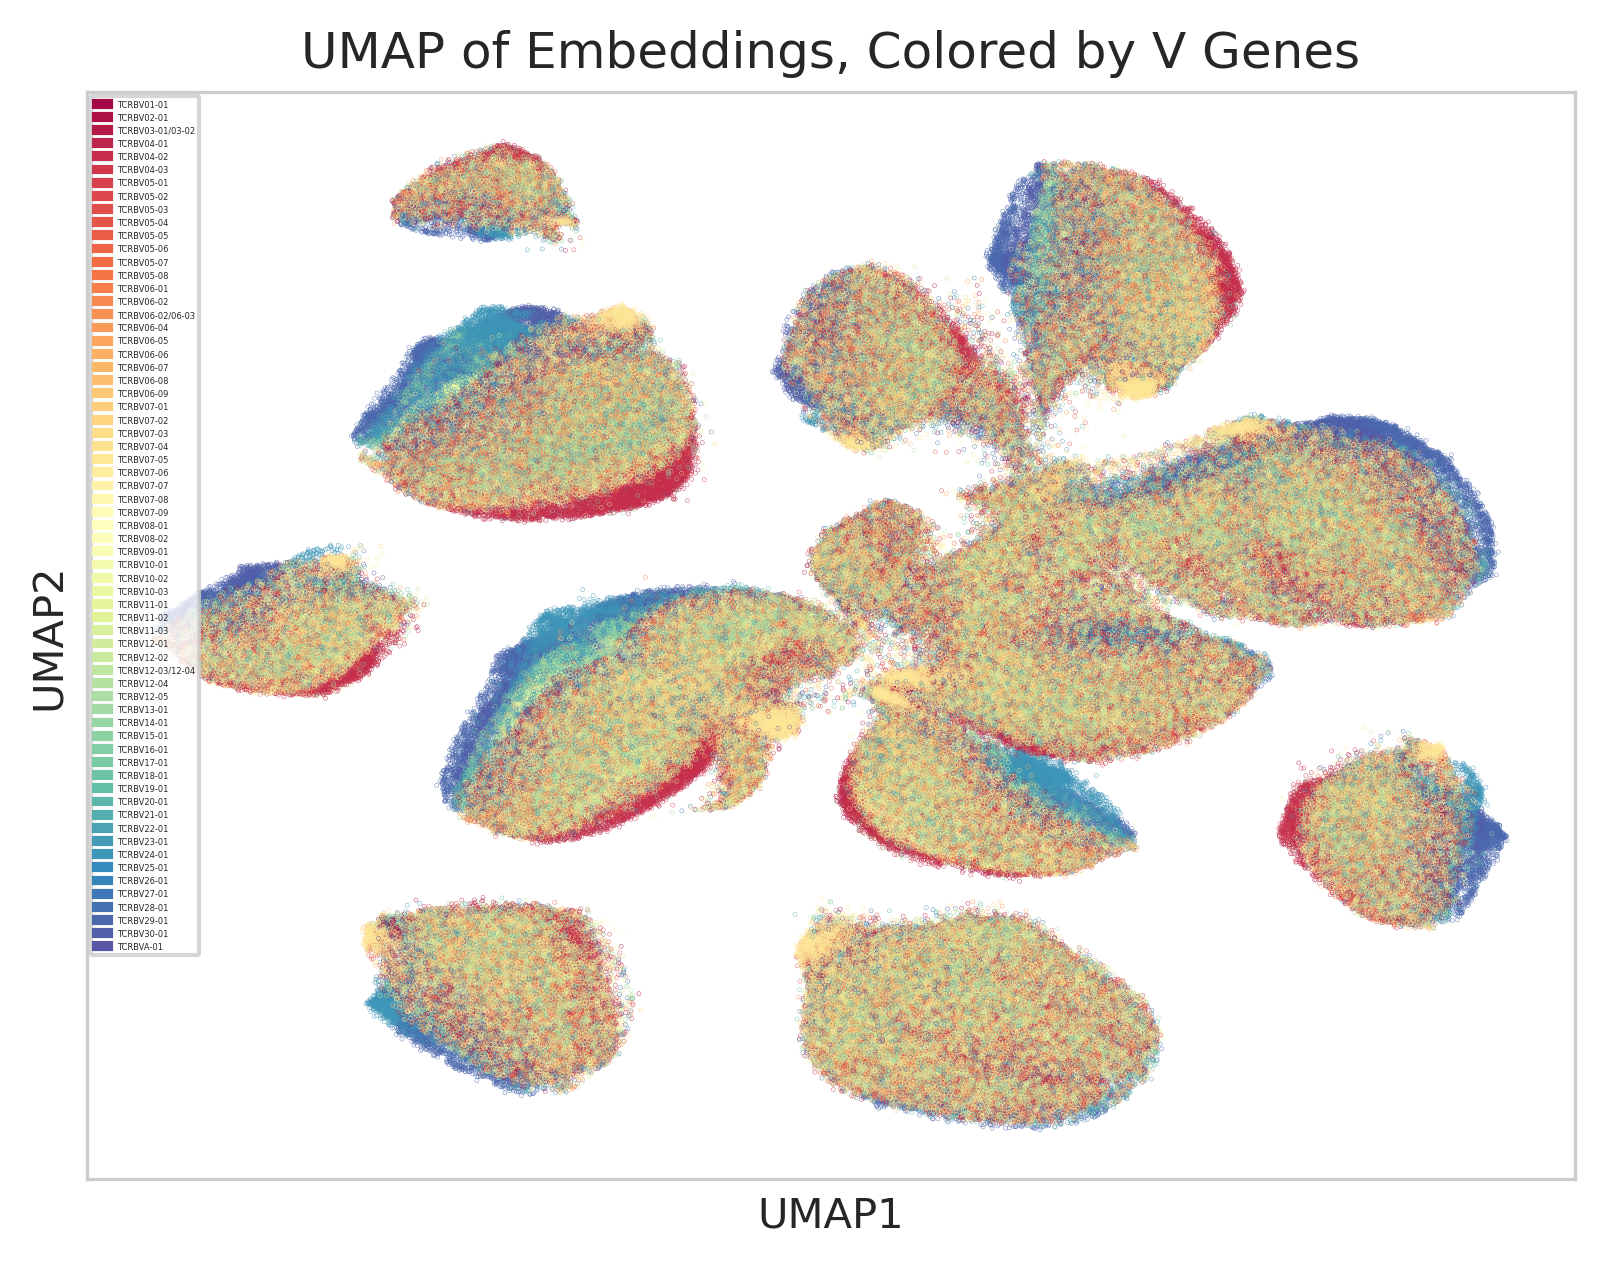

In [40]:
colors = ['gold', 'darkblue']#, 'maroon'] #cmap=plt.get_cmap('Set1)'
importlib.reload(plot_utils)
plot_utils.plot_anndata_rep(
    tcrb_embeddings_adata,
    # color='jGeneName',
    color='vGeneName',
    # color='Private_Public_label',
    direct_label=False,
    cmap= color_map,
    # cmap=matplotlib.colors.ListedColormap(colors),
    #title="UMAP of Embeddings, Colored by J Genes",
    title="UMAP of Embeddings, Colored by V Genes",
    # title="UMAP of Embeddings, Colored by Public/Private Label",
    legend_size=2,
    # fname=os.path.join(PLOT_DIR, "tcr_model_db_data_umap_j_genes.pdf"),
    fname=os.path.join(PLOT_DIR, "tcr_model_db_data_umap_v_genes.pdf"),
    # fname=os.path.join(PLOT_DIR, "tcr_model_db_data_umap_j_genes_pub_priv.pdf"),
).show()